# Part 2, XGBoost

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import sys
# import pickle 

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
# from sklearn.grid_search import GridSearchCV
from scipy.sparse import csr_matrix, hstack
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

## Data preprocessing

In [3]:
train = pd.read_csv('train.csv')

log-transform

In [4]:
train['log_loss'] = np.log(train['loss'])

Divide categorical and numerical features:

In [5]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

categoricalFeatures = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss', 'log_loss']]
numericalFeatures = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print(f"Categorical features: {len(categoricalFeatures)}")
print(f"Numerical features: {len(numericalFeatures)}")

Categorical features: 116
Numerical features: 14


In [6]:
ntrain = train.shape[0]

xTrain = train[features]
yTrain = train['log_loss']

for featureIndex in range(len(categoricalFeatures)):
    xTrain[categoricalFeatures[featureIndex]] = xTrain[categoricalFeatures[featureIndex]].astype('category').cat.codes
    
print("Xtrain:", xTrain.shape)
print("ytrain:", yTrain.shape)

Xtrain: (188318, 130)
ytrain: (188318,)


## XGBoost Model

In [7]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

### Model

In [8]:
dtrain = xgb.DMatrix(xTrain, train['log_loss'])

parameters for XGBoost

In [9]:
xgb_params = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'min_child_weight': 3
}

Now we run XGBoost and cross validate the results via the built-in `xgb.cv` function and `xg_eval_mae` function for calculating the loss (MAE).

In [ ]:
bst_cv1 = None
        
# else:
bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=50, nfold=3, seed=0, feval=xg_eval_mae, maximize=False, early_stopping_rounds=10)
# bst_cv1 = GridSearchCV()
print('CV score:', bst_cv1.iloc[-1,:]['test-mae-mean'])

# print(bst_cv1)

plt.figure()
bst_cv1[['train-mae-mean', 'test-mae-mean']].plot()

We got the first baseline result: `MAE=1204.55`. 

We plot the training and test errors above as well.

Initial thoughts:

Seems to be little to no overfitting-- training and test losses are not very wide spread


Loss is decreasing after round 50


Let's try with a more complex model: 100 trees [note, this will be very slow to try and run without the use of resources such as Amazon AWS AMI]

In [11]:


bst_cv2 = xgb.cv(xgb_params, dtrain, num_boost_round=100, 
                nfold=3, seed=0, feval=xg_eval_mae, maximize=False, 
                early_stopping_rounds=10)

print('CV score:', bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 1171.2875569999999


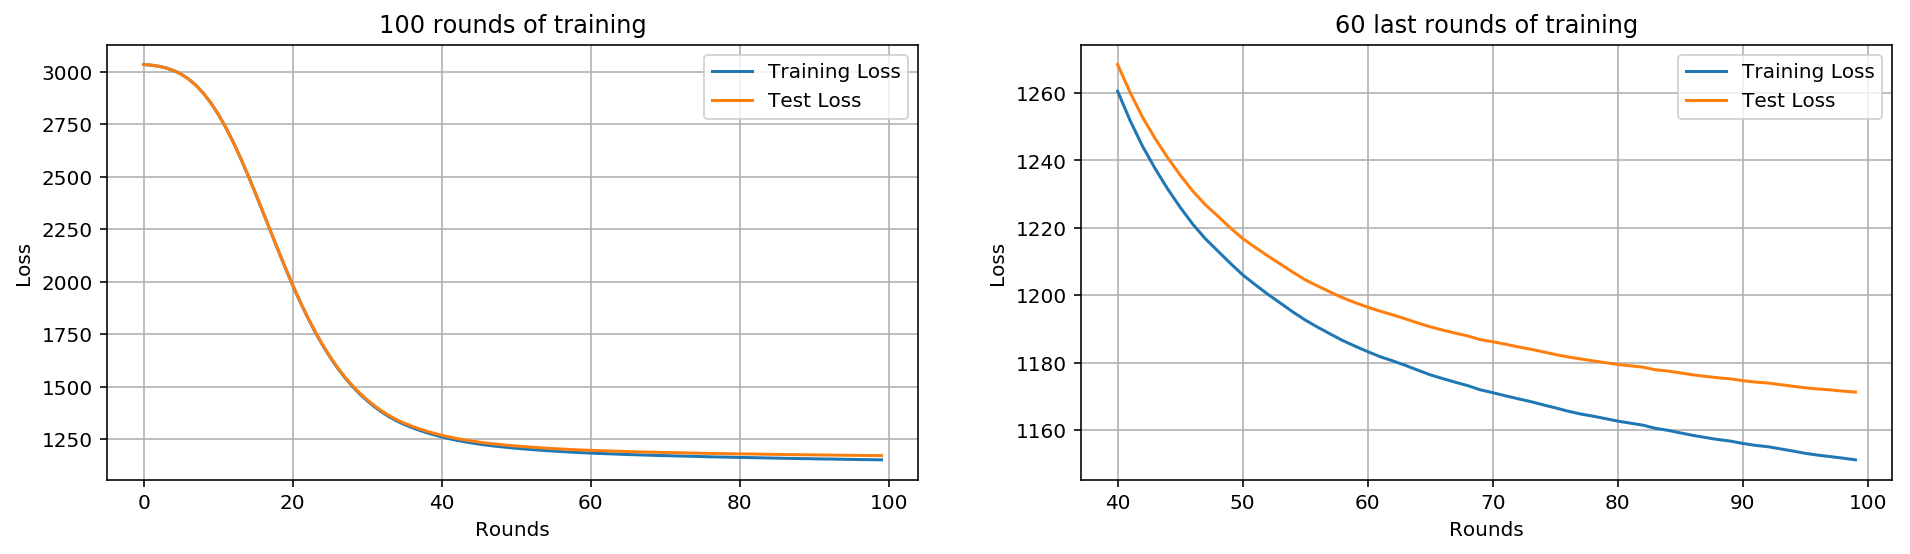

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean', 'test-mae-mean']])
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean', 'test-mae-mean']])
ax2.legend(['Training Loss', 'Test Loss']) 

We note that the gap between training and test loss widens with each new round. While this might not be the best performing model, we are still good, since there is no evidence of overfitting.

## XGBoost Tuning

Now we have two models: `bst_cv1` (basic) and `bst_cv2` (with more trees). To simplify and accelerate learning, we go on with the basic model, tune and memorize the hyperparameters and implement a new learner with those hyperparameters based on `bst_cv2`.

The final model will get additional base estimators.

* Step 1: Set reasonable initial learining rate and a number of estimators.


* Step 2: Tuning `max_depth` and `min_child_weight`.


* Step 3: Tuning `gamma` to reduce overfitting.


* Step 4: Tuning `subsample` and `colsample_bytree`.


* Step 5: Reducing learning rate `eta`, adding more estimators.

In [14]:
def mae_score(y_true, y_pred):
    return mean_absolute_error(np.exp(y_true), np.exp(y_pred))

mae_scorer = make_scorer(mae_score, greater_is_better=False)

Now we can test our new class:

In [15]:
bst = xgb.XGBRegressor(eta=0.1, colsample_bytree=0.5, subsample=0.5, 
                       max_depth=5, min_child_weight=3, num_boost_round=50)
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(bst, xTrain, yTrain, cv=kfold) 
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[17:32:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:33:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:35:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:38:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:39:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:41:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:42:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:44:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

This looks similar to what we got earlier with 50 trees, so that we are safe to continue.

Tuning parameters

In [16]:
xgb_param_grid = {'min_child_weight': (1,3,6), 'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9],
                 'colsample_bytree':[0.5], 'subsample':[0.5]}


In [17]:

regressor = xgb.XGBRegressor()
grid = GridSearchCV(estimator = regressor, param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)


grid.fit(xTrain, yTrain.values)

[17:47:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:48:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:49:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:50:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:51:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:53:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:54:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:56:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [18]:
grid.grid_scores_, grid.best_params_, grid.best_score_

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

The best result found by this grid search:

`{'max_depth': 8, 'min_child_weight': 6},
 -1186.5963814064248)`
 
A negative value is a convention of `GridSearchCV` (always search for a maximum).

To understand the relationship between `max_depth` and `min_child_weight`, we draw a contour plot. First, we facilitate retrieving data from `grid.grid_scores_`:

In [ ]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [ ]:
_, _, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,3)

Now we plot the chart:

In [ ]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'], xgb_param_grid['max_depth'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()

As we see from the results of grid search, score mainly seems to improve when the max_depth parameter is increased

We see that min_child_weight=6 is pretty good.

Gamma Tuning

In [ ]:

xgb_param_grid = {'gamma':[ 0.1 * i for i in range(0,5)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1, num_boost_round=50, max_depth=8, min_child_weight=6,
                                     colsample_bytree=0.5, subsample=0.5),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(xTrain, yTrain.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

Tuning parameters: colsample_bytree, subsample

In [19]:

xgb_param_grid = {'subsample':[ 0.1 * i for i in range(5,10)],
                      'colsample_bytree':[ 0.1 * i for i in range(5,10)]}


grid = GridSearchCV(XGBoostRegressor(eta=0.1, gamma=0.2, num_boost_round=50, max_depth=8, min_child_weight=6),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)
grid.fit(xTrain, yTrain.values)

NameError: name 'XGBoostRegressor' is not defined

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
_, _, scores =  convert_grid_scores(grid.grid_scores_)
scores = scores.reshape(5,5)

plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['subsample'], xgb_param_grid['colsample_bytree'], scores, cmap='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum', xy=(0.895, 0.6), xytext=(0.8, 0.695), arrowprops=dict(facecolor='black'))
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)
plt.show()

The current model yields the following:

`{'colsample_bytree': 0.6, 'subsample': 0.9},
 -1176.6672029537717)`


Let's see how various learning rates affect the performance of a simpler model, with only 50 trees. 

In [ ]:

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50, gamma=0.2, max_depth=8, min_child_weight=6,
                                     colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(xTrain, yTrain.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 50 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, ""-y)
plt.grid(True)
plt.show()

Now, we will experiment with the number of trees. 

In [ ]:
xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05,0.04,0.03]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100, gamma=0.2, max_depth=8, min_child_weight=6,
                                     colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(xTrain, yTrain.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 100 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [ ]:

xgb_param_grid = {'eta':[0.09,0.08,0.07,0.06,0.05,0.04]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=200, gamma=0.2, max_depth=8, min_child_weight=6,
                                     colsample_bytree=0.6, subsample=0.9),
                    param_grid=xgb_param_grid, cv=5, scoring=mae_scorer)

grid.fit(xTrain, yTrain.values)

In [ ]:
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
eta, y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('MAE and ETA, 200 trees')
plt.xlabel('eta')
plt.ylabel('score')
plt.plot(eta, -y)
plt.grid(True)
plt.show()

In [ ]:

# FINAL MODEL


bst = XGBoostRegressor(num_boost_round=200, eta=0.07, gamma=0.2, max_depth=8, min_child_weight=6,
                                     colsample_bytree=0.6, subsample=0.9)
cv = bst.kfold(xTrain, yTrain, nfold=5)

In [ ]:
cv

We see that the best `eta` for using 200 trees is 0.07. Note that the correlation between `eta` and `num_boost_round` is nonlinear.

To summarize:

the initial score: **1219.55**. After doing grid search, this model (with fixed `eta` and `num_boost_round`) scored **MAE=1184.43**.

In [ ]:
print('done!')